In [1]:
# Analyze latent space utilization
import torch
def analyze_latent_usage(model, dataloader, device):
    model.eval()
    all_mu = []
    all_logvar = []
    
    with torch.no_grad():
        for batch in dataloader:
            frames = extract_frame(batch, frame_idx=200).to(device)
            mu, logvar = model.encode(frames)
            all_mu.append(mu.cpu())
            all_logvar.append(logvar.cpu())
    
    all_mu = torch.cat(all_mu, dim=0)
    all_logvar = torch.cat(all_logvar, dim=0)
    
    # Check active dimensions
    mu_std = all_mu.std(dim=0)
    active_dims = (mu_std > 0.1).sum().item()
    
    print(f"Active dimensions: {active_dims}/{all_mu.shape[1]}")
    print(f"Mean KL per dimension: {-0.5 * (1 + all_logvar - all_mu.pow(2) - all_logvar.exp()).mean(dim=0)}")
    
    return all_mu, all_logvar

Using device: cpu
Loading dataset...
Using Torch version: 2.6.0+cu124
Data directory set to:
	/home/lsanche1/Documents/bp_prediction/data
Found HDF5 data: 'subject001_baseline_masked.h5'
Loading metadata...
	 ...Done!
PviDataset successfully initiated!
Loading raw data...
	 ...Done! (0.27 seconds)
Number of periods: 867
Stacking samples (400 total):
	 ...100/400 samples
	 ...200/400 samples
	 ...300/400 samples
	 ...400/400 samples
	 ...Done! (4.72 seconds)
Number of samples: 400
Finish loading PviDataset!
PviBatchServer successfully initiated!
Loading trained model...
Loaded model from epoch 94 with loss 20.0702

Running latent space analysis...


100%|██████████| 5/5 [00:00<00:00, 65.24it/s]


=== Latent Space Analysis ===
Total dimensions: 512
Active dimensions (std > 0.1): 501
Barely active dimensions (0.05 < std <= 0.1): 11
Inactive dimensions (std <= 0.05): 0
Utilization rate: 97.9%
Mean KL divergence: 0.0454
Max KL divergence: 2.0987
Number of samples analyzed: 80


Analysis plots saved to: /home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/analysis/latent_analysis.png


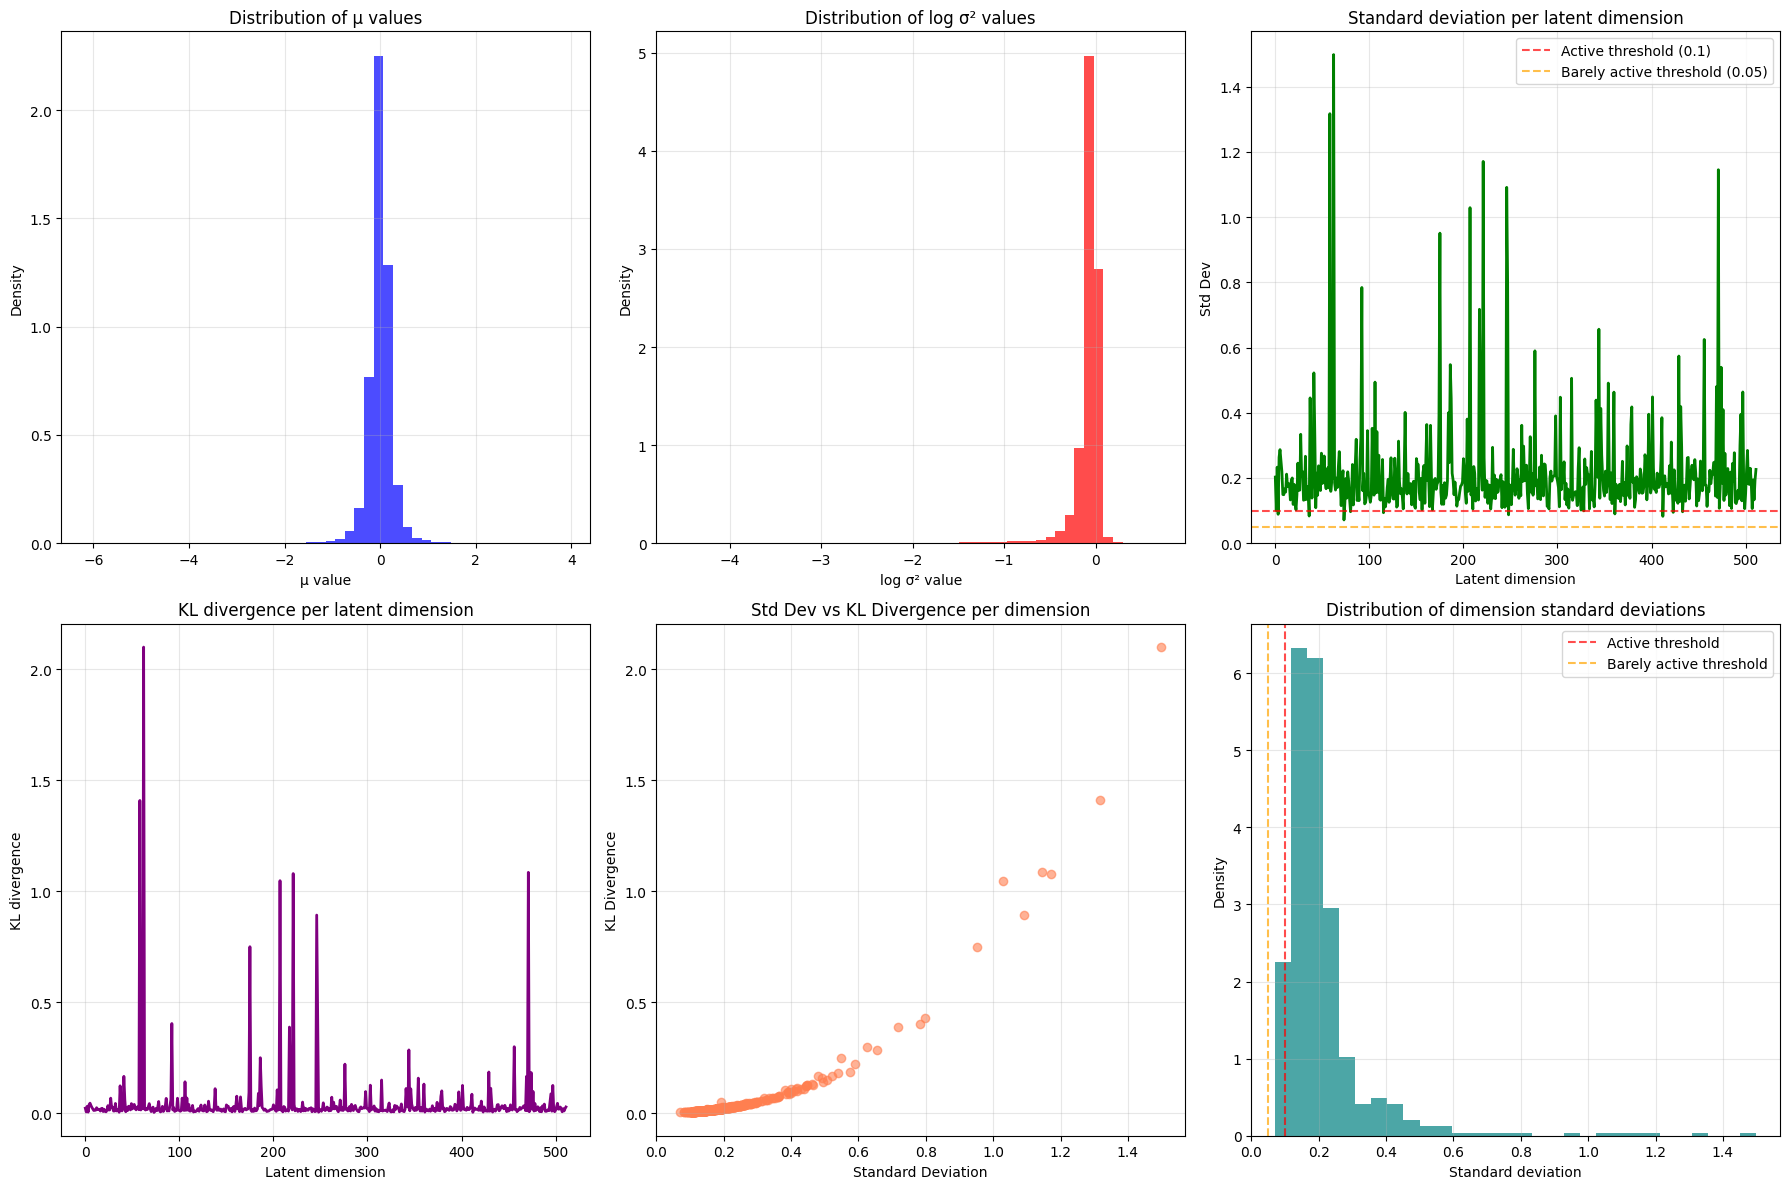


Analyzing sample reconstructions...


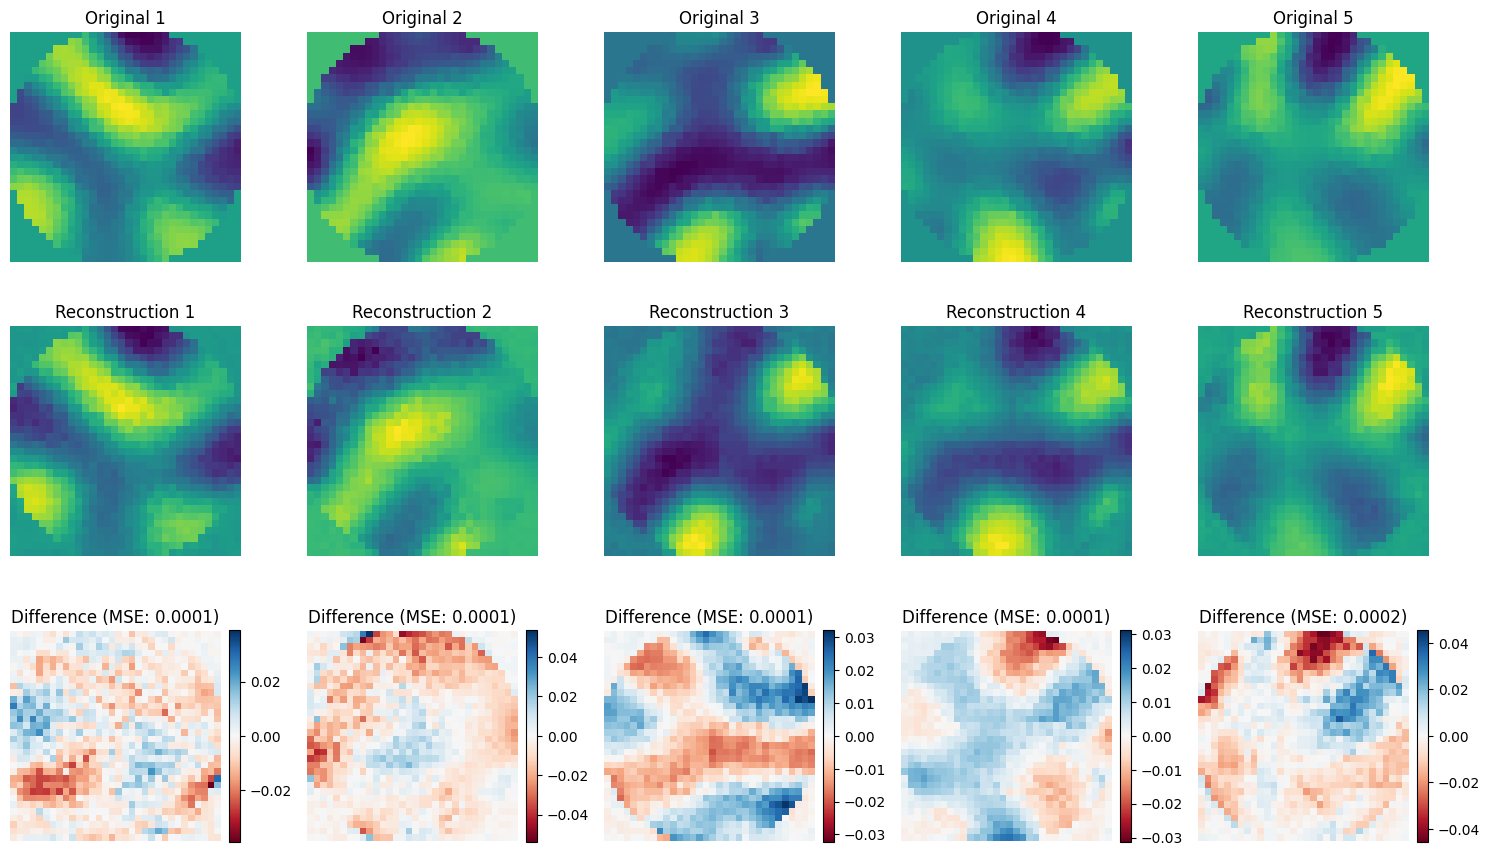


Reconstruction errors: [8.26864052e-05 1.49802203e-04 1.20284814e-04 6.93021866e-05
 1.60029434e-04]
Mean reconstruction error: 0.0001
Std reconstruction error: 0.0000

FINAL ANALYSIS SUMMARY
latent_dim: 512
total_samples: 80
active_dimensions: 501
barely_active_dimensions: 11
inactive_dimensions: 0
utilization_rate: 97.8516
mean_kl_divergence: 0.0454
max_kl_divergence: 2.0987
mean_reconstruction_error: 0.0001
std_reconstruction_error: 0.0000

Analysis complete! Results saved to: /home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/analysis


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import sys

# Add the parent directory to the path to find utils
#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
from utils.data_utils import PviDataset, PviBatchServer

# Import your VAE model
from tuned_vae import VAE, extract_frame

def analyze_latent_usage(model, dataloader, device, frame_idx=200):
    """Analyze how the latent space is being utilized"""
    model.eval()
    all_mu = []
    all_logvar = []
    all_samples = []
    
    print("Collecting latent representations...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            try:
                frames = extract_frame(batch, frame_idx).to(device)
                mu, logvar = model.encode(frames)
                all_mu.append(mu.cpu())
                all_logvar.append(logvar.cpu())
                all_samples.append(frames.cpu())
                
                # Limit to reasonable number of samples for analysis
                if batch_idx > 20:  # Adjust based on your needs
                    break
                    
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                continue
    
    all_mu = torch.cat(all_mu, dim=0)
    all_logvar = torch.cat(all_logvar, dim=0)
    all_samples = torch.cat(all_samples, dim=0)
    
    # Calculate statistics
    mu_std = all_mu.std(dim=0)
    mu_mean = all_mu.mean(dim=0)
    logvar_mean = all_logvar.mean(dim=0)
    
    # Check active dimensions (dimensions with meaningful variation)
    active_dims = (mu_std > 0.1).sum().item()
    barely_active = ((mu_std > 0.05) & (mu_std <= 0.1)).sum().item()
    inactive_dims = (mu_std <= 0.05).sum().item()
    
    # Calculate KL divergence per dimension
    kl_per_dim = -0.5 * (1 + all_logvar - all_mu.pow(2) - all_logvar.exp()).mean(dim=0)
    
    print(f"\n=== Latent Space Analysis ===")
    print(f"Total dimensions: {all_mu.shape[1]}")
    print(f"Active dimensions (std > 0.1): {active_dims}")
    print(f"Barely active dimensions (0.05 < std <= 0.1): {barely_active}")
    print(f"Inactive dimensions (std <= 0.05): {inactive_dims}")
    print(f"Utilization rate: {active_dims/all_mu.shape[1]*100:.1f}%")
    print(f"Mean KL divergence: {kl_per_dim.mean().item():.4f}")
    print(f"Max KL divergence: {kl_per_dim.max().item():.4f}")
    print(f"Number of samples analyzed: {all_mu.shape[0]}")
    
    return all_mu, all_logvar, all_samples, mu_std, kl_per_dim

def plot_latent_analysis(mu, logvar, mu_std, kl_per_dim, save_path=None):
    """Create comprehensive plots of latent space analysis"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Distribution of μ values
    axes[0, 0].hist(mu.flatten().numpy(), bins=50, alpha=0.7, color='blue', density=True)
    axes[0, 0].set_title('Distribution of μ values')
    axes[0, 0].set_xlabel('μ value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribution of log σ² values
    axes[0, 1].hist(logvar.flatten().numpy(), bins=50, alpha=0.7, color='red', density=True)
    axes[0, 1].set_title('Distribution of log σ² values')
    axes[0, 1].set_xlabel('log σ² value')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Standard deviation per latent dimension
    axes[0, 2].plot(mu_std.numpy(), color='green', linewidth=2)
    axes[0, 2].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Active threshold (0.1)')
    axes[0, 2].axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Barely active threshold (0.05)')
    axes[0, 2].set_title('Standard deviation per latent dimension')
    axes[0, 2].set_xlabel('Latent dimension')
    axes[0, 2].set_ylabel('Std Dev')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. KL divergence per dimension
    axes[1, 0].plot(kl_per_dim.numpy(), color='purple', linewidth=2)
    axes[1, 0].set_title('KL divergence per latent dimension')
    axes[1, 0].set_xlabel('Latent dimension')
    axes[1, 0].set_ylabel('KL divergence')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Scatter plot: Std Dev vs KL Divergence
    axes[1, 1].scatter(mu_std.numpy(), kl_per_dim.numpy(), alpha=0.6, color='coral')
    axes[1, 1].set_xlabel('Standard Deviation')
    axes[1, 1].set_ylabel('KL Divergence')
    axes[1, 1].set_title('Std Dev vs KL Divergence per dimension')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Histogram of standard deviations (to see distribution of activity)
    axes[1, 2].hist(mu_std.numpy(), bins=30, alpha=0.7, color='teal', density=True)
    axes[1, 2].axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Active threshold')
    axes[1, 2].axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Barely active threshold')
    axes[1, 2].set_title('Distribution of dimension standard deviations')
    axes[1, 2].set_xlabel('Standard deviation')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Analysis plots saved to: {save_path}")
    
    plt.show()

def analyze_sample_reconstructions(model, samples, device, n_samples=5):
    """Analyze reconstruction quality for specific samples"""
    model.eval()
    
    with torch.no_grad():
        # Select random samples
        indices = torch.randperm(samples.shape[0])[:n_samples]
        selected_samples = samples[indices].to(device)
        
        # Get reconstructions
        recon, mu, logvar = model(selected_samples)
        
        # Calculate reconstruction error per sample
        recon_errors = F.mse_loss(recon, selected_samples, reduction='none').mean(dim=[1, 2, 3])
        
        # Plot comparison
        fig, axes = plt.subplots(3, n_samples, figsize=(15, 9))
        
        for i in range(n_samples):
            # Original
            axes[0, i].imshow(selected_samples[i, 0].cpu().numpy(), cmap='viridis', origin='lower')
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Reconstruction
            axes[1, i].imshow(recon[i, 0].cpu().numpy(), cmap='viridis', origin='lower')
            axes[1, i].set_title(f'Reconstruction {i+1}')
            axes[1, i].axis('off')
            
            # Difference
            diff = (selected_samples[i, 0] - recon[i, 0]).cpu().numpy()
            im = axes[2, i].imshow(diff, cmap='RdBu', origin='lower', 
                                  vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
            axes[2, i].set_title(f'Difference (MSE: {recon_errors[i]:.4f})')
            axes[2, i].axis('off')
            plt.colorbar(im, ax=axes[2, i], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()
        
        return recon_errors

def main():
    # Set up paths and parameters
    data_path = "/home/lsanche1/Documents/bp_prediction/data/subject001_baseline_masked.h5"
    model_path = "/home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/checkpoints/vae_best.pt"
    output_dir = "/home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/analysis"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load dataset and create data loader
    print("Loading dataset...")
    dataset = PviDataset(data_path)
    batch_server = PviBatchServer(dataset, input_type="img", output_type="full")
    batch_server.set_loader_params(batch_size=16, test_size=0.2)
    train_loader, test_loader = batch_server.get_loaders()
    
    # Load the trained model
    print("Loading trained model...")
    model = VAE(latent_dim=512)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    print(f"Loaded model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
    
    # Run latent space analysis
    print("\nRunning latent space analysis...")
    mu, logvar, samples, mu_std, kl_per_dim = analyze_latent_usage(model, test_loader, device, frame_idx=200)
    
    # Create comprehensive plots
    plot_save_path = os.path.join(output_dir, 'latent_analysis.png')
    plot_latent_analysis(mu, logvar, mu_std, kl_per_dim, save_path=plot_save_path)
    
    # Analyze sample reconstructions
    print("\nAnalyzing sample reconstructions...")
    recon_errors = analyze_sample_reconstructions(model, samples, device, n_samples=5)
    
    print(f"\nReconstruction errors: {recon_errors.numpy()}")
    print(f"Mean reconstruction error: {recon_errors.mean().item():.4f}")
    print(f"Std reconstruction error: {recon_errors.std().item():.4f}")
    
    # Save analysis results
    analysis_results = {
        'latent_dim': 512,
        'total_samples': mu.shape[0],
        'active_dimensions': (mu_std > 0.1).sum().item(),
        'barely_active_dimensions': ((mu_std > 0.05) & (mu_std <= 0.1)).sum().item(),
        'inactive_dimensions': (mu_std <= 0.05).sum().item(),
        'utilization_rate': (mu_std > 0.1).sum().item() / mu.shape[1] * 100,
        'mean_kl_divergence': kl_per_dim.mean().item(),
        'max_kl_divergence': kl_per_dim.max().item(),
        'mean_reconstruction_error': recon_errors.mean().item(),
        'std_reconstruction_error': recon_errors.std().item()
    }
    
    # Print summary
    print("\n" + "="*50)
    print("FINAL ANALYSIS SUMMARY")
    print("="*50)
    for key, value in analysis_results.items():
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
    
    print(f"\nAnalysis complete! Results saved to: {output_dir}")

if __name__ == "__main__":
    main()

Using device: cpu
Loading PVI dataset...
Using Torch version: 2.6.0+cu124
Data directory set to:
	/home/lsanche1/Documents/bp_prediction/data
Found HDF5 data: 'subject001_baseline_masked.h5'
Loading metadata...
	 ...Done!
PviDataset successfully initiated!
Loading raw data...
	 ...Done! (0.34 seconds)
Number of periods: 867
Stacking samples (400 total):
	 ...100/400 samples
	 ...200/400 samples
	 ...300/400 samples
	 ...400/400 samples
	 ...Done! (5.51 seconds)
Number of samples: 400
Finish loading PviDataset!
PVI dataset loaded with 400 samples
Loading BP data...
Available keys in HDF5 file:
['data', 'metadata', 'stats']
BP data not found. Creating synthetic BP data for testing...
Created synthetic BP data shape: (400, 50)
BP data shape: (400, 50)
Loading trained VAE model...
Loaded VAE model from epoch 96 with loss 27.0600
Extracting embeddings for up to 100 samples, 50 frames each...
PviBatchServer successfully initiated!


Extracting embeddings:  25%|██▌       | 100/399 [00:05<00:15, 19.29it/s]


Extracted embeddings shape: torch.Size([100, 50, 512])
Final embeddings shape: torch.Size([100, 50, 512])
Final BP data shape: (100, 50)

STARTING BP PREDICTION EVALUATION

=== TEMPORAL CONSISTENCY ANALYSIS ===
Overall temporal consistency: 0.9684
Consistency std: 0.0140
Min consistency: 0.9183
Max consistency: 0.9906
Quality Assessment: ✅ EXCELLENT - Very smooth temporal embeddings

=== BP CORRELATION ANALYSIS ===
Analyzing correlations for 5000 data points
Embedding dimension: 512


Calculating correlations: 100%|██████████| 512/512 [00:00<00:00, 4023.21it/s]


High correlation dimensions (>0.3): 0
Medium correlation dimensions (0.1-0.3): 0
Low correlation dimensions (<=0.1): 512
Significant correlations (p<0.05, |r|>0.1): 0
Max correlation: 0.0509
Mean correlation: 0.0143
Utilization for BP: 0.0%
Quality Assessment: ❌ POOR - No meaningful BP correlations

=== LINEAR PREDICTABILITY TEST ===
Training samples: 4000
Test samples: 1000
Linear Regression R²: -0.1655
Linear Regression Correlation: 0.0247
Linear Regression MAE: 8.6277
Linear Regression RMSE: 10.8209
Quality Assessment: ❌ POOR - No linear predictability

=== SEQUENCE MODELING ANALYSIS ===
Average sequence modeling R²: -102.0218
Sequence modeling std: 117.6329
Number of sequences tested: 20
Quality Assessment: ❌ POOR - No sequence modeling capability

=== CREATING VISUALIZATIONS ===
BP analysis plots saved to: /home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/bp_analysis/bp_prediction_analysis.png


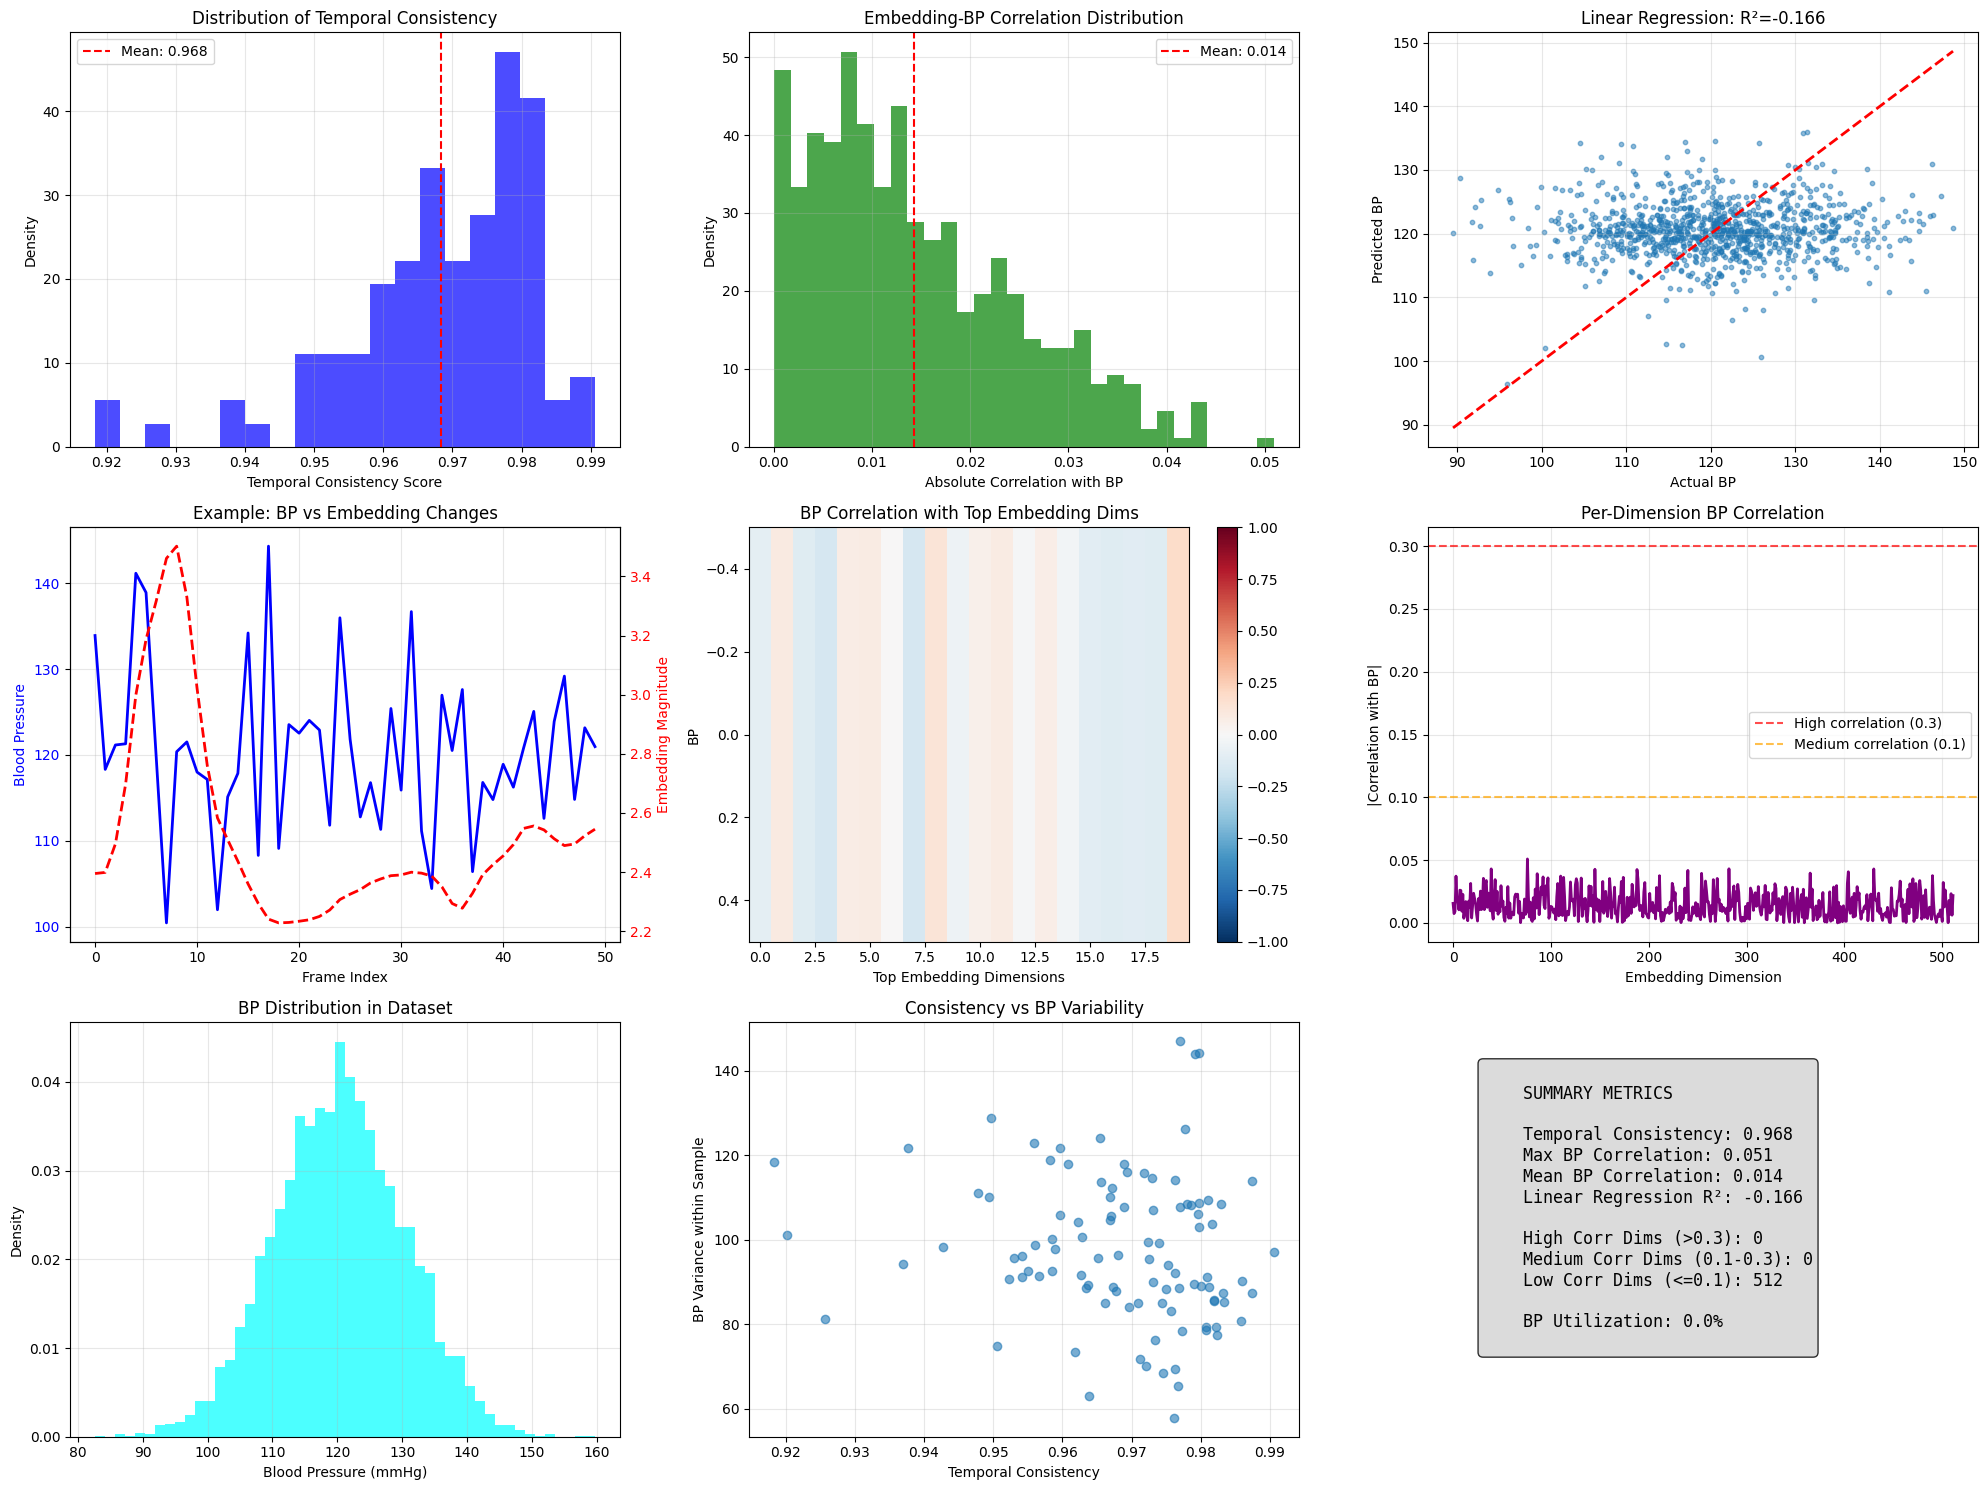


FINAL BP PREDICTION ASSESSMENT
Temporal Consistency: 0.9684
  → ✅ EXCELLENT
Max BP Correlation: 0.0509
  → ❌ POOR
Mean BP Correlation: 0.0143
  → ❌ POOR
Linear R²: -0.1655
  → ❌ POOR
Sequence Modeling R²: -102.0218
  → ❌ POOR

Overall Quality Score: 1.60/4.0

⚠️ MODERATE - BiLSTM may work but consider VAE improvements

=== RECOMMENDATIONS FOR BiLSTM BP PREDICTION ===
⚠️ Consider VAE improvements before BiLSTM:
  1. Poor BP correlation - consider supervised fine-tuning
  2. Poor BP correlation - consider supervised fine-tuning
  3. Consider non-linear models (BiLSTM should help)

Analysis complete! Results saved to: /home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/bp_analysis
Summary: {'temporal_consistency': np.float64(0.9683672533518805), 'max_bp_correlation': np.float64(0.05093951743131182), 'mean_bp_correlation': np.float64(0.014308366173915652), 'linear_r2': -0.16553337151899017, 'sequence_r2': np.float64(-102.02182400462492), 'overall_quality': np.float64(1.6), 

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from tqdm import tqdm
import os
import sys
import h5py

# Add the parent directory to the path to find utils
#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
from utils.data_utils import PviDataset, PviBatchServer

# Import your VAE model
from tuned_vae import VAE, extract_frame

def load_bp_data(data_path):
    """Load BP data from HDF5 file - modify this based on your data structure"""
    print("Loading BP data...")
    
    # You'll need to modify this based on how your BP data is stored
    # This is a placeholder - replace with your actual BP data loading
    try:
        with h5py.File(data_path, 'r') as f:
            # Look for BP data in the HDF5 file
            # Common names might be: 'bp', 'blood_pressure', 'arterial_pressure', etc.
            print("Available keys in HDF5 file:")
            print(list(f.keys()))
            
            # Try to find BP data - modify these key names based on your file structure
            possible_bp_keys = ['bp', 'blood_pressure', 'arterial_pressure', 'abp', 'pressure']
            bp_data = None
            
            for key in possible_bp_keys:
                if key in f.keys():
                    bp_data = f[key][:]
                    print(f"Found BP data under key: '{key}'")
                    print(f"BP data shape: {bp_data.shape}")
                    break
            
            if bp_data is None:
                print("BP data not found. Creating synthetic BP data for testing...")
                # Create synthetic BP data for testing
                # Assumes you have samples similar to PVI data
                # You'll need to replace this with actual BP loading
                n_samples = 400  # Adjust based on your dataset
                frames_per_sample = 50
                bp_data = np.random.randn(n_samples, frames_per_sample) * 10 + 120  # Synthetic BP around 120 mmHg
                print(f"Created synthetic BP data shape: {bp_data.shape}")
    
    except Exception as e:
        print(f"Error loading BP data: {e}")
        print("Creating synthetic BP data for testing...")
        n_samples = 400
        frames_per_sample = 50
        bp_data = np.random.randn(n_samples, frames_per_sample) * 10 + 120
        print(f"Created synthetic BP data shape: {bp_data.shape}")
    
    return bp_data

def extract_all_embeddings(model, dataset, device, frames_per_sample=50, max_samples=100):
    """Extract VAE embeddings for all samples and all frames"""
    model.eval()
    all_embeddings = []
    sample_count = 0
    
    print(f"Extracting embeddings for up to {max_samples} samples, {frames_per_sample} frames each...")
    
    # Create a simple dataloader to iterate through samples
    batch_server = PviBatchServer(dataset, input_type="img", output_type="full")
    batch_server.set_loader_params(batch_size=1, test_size=0.001)  # Use almost all data, batch_size=1
    train_loader, _ = batch_server.get_loaders()
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(train_loader, desc="Extracting embeddings")):
            if sample_count >= max_samples:
                break
                
            try:
                sample_embeddings = []
                
                # Extract embeddings for all frames in this sample
                for frame_idx in range(frames_per_sample):
                    frame = extract_frame(batch_data, frame_idx).to(device)
                    mu, _ = model.encode(frame)
                    sample_embeddings.append(mu.cpu().squeeze(0))
                
                # Stack frame embeddings for this sample
                sample_embeddings = torch.stack(sample_embeddings)  # [frames_per_sample, embedding_dim]
                all_embeddings.append(sample_embeddings)
                sample_count += 1
                
            except Exception as e:
                print(f"Error processing sample {batch_idx}: {e}")
                continue
    
    # Stack all sample embeddings
    all_embeddings = torch.stack(all_embeddings)  # [n_samples, frames_per_sample, embedding_dim]
    print(f"Extracted embeddings shape: {all_embeddings.shape}")
    
    return all_embeddings

def analyze_temporal_consistency(embeddings):
    """Analyze temporal consistency within samples"""
    print("\n=== TEMPORAL CONSISTENCY ANALYSIS ===")
    
    n_samples, frames_per_sample, embedding_dim = embeddings.shape
    temporal_consistency_scores = []
    
    for sample_idx in range(n_samples):
        sample_embeddings = embeddings[sample_idx]  # [frames, embedding_dim]
        
        # Calculate cosine similarities between consecutive frames
        consecutive_similarities = []
        for frame_idx in range(frames_per_sample - 1):
            sim = F.cosine_similarity(
                sample_embeddings[frame_idx].unsqueeze(0),
                sample_embeddings[frame_idx + 1].unsqueeze(0)
            ).item()
            consecutive_similarities.append(sim)
        
        avg_consistency = np.mean(consecutive_similarities)
        temporal_consistency_scores.append(avg_consistency)
    
    overall_consistency = np.mean(temporal_consistency_scores)
    consistency_std = np.std(temporal_consistency_scores)
    
    print(f"Overall temporal consistency: {overall_consistency:.4f}")
    print(f"Consistency std: {consistency_std:.4f}")
    print(f"Min consistency: {np.min(temporal_consistency_scores):.4f}")
    print(f"Max consistency: {np.max(temporal_consistency_scores):.4f}")
    
    # Quality assessment
    if overall_consistency > 0.85:
        quality = "✅ EXCELLENT - Very smooth temporal embeddings"
    elif overall_consistency > 0.75:
        quality = "✅ GOOD - Reasonably smooth temporal embeddings"
    elif overall_consistency > 0.6:
        quality = "⚠️ MODERATE - Some temporal smoothness"
    else:
        quality = "❌ POOR - Embeddings are temporally inconsistent"
    
    print(f"Quality Assessment: {quality}")
    
    return temporal_consistency_scores, overall_consistency

def analyze_bp_correlation(embeddings, bp_data):
    """Analyze correlation between embeddings and BP values"""
    print("\n=== BP CORRELATION ANALYSIS ===")
    
    n_samples, frames_per_sample, embedding_dim = embeddings.shape
    
    # Flatten embeddings and BP for correlation analysis
    embeddings_flat = embeddings.view(-1, embedding_dim)  # [n_samples*frames, embedding_dim]
    bp_flat = bp_data.flatten()  # [n_samples*frames]
    
    print(f"Analyzing correlations for {embeddings_flat.shape[0]} data points")
    print(f"Embedding dimension: {embedding_dim}")
    
    # Calculate correlation for each embedding dimension
    embedding_bp_correlations = []
    significant_correlations = 0
    
    for dim in tqdm(range(embedding_dim), desc="Calculating correlations"):
        embedding_values = embeddings_flat[:, dim].numpy()
        correlation, p_value = pearsonr(embedding_values, bp_flat)
        
        # Store absolute correlation
        abs_correlation = abs(correlation)
        embedding_bp_correlations.append(abs_correlation)
        
        # Count significant correlations (p < 0.05 and |correlation| > 0.1)
        if p_value < 0.05 and abs_correlation > 0.1:
            significant_correlations += 1
    
    embedding_bp_correlations = np.array(embedding_bp_correlations)
    
    # Analyze correlation distribution
    high_corr_dims = (embedding_bp_correlations > 0.3).sum()
    medium_corr_dims = ((embedding_bp_correlations > 0.1) & (embedding_bp_correlations <= 0.3)).sum()
    low_corr_dims = (embedding_bp_correlations <= 0.1).sum()
    
    print(f"High correlation dimensions (>0.3): {high_corr_dims}")
    print(f"Medium correlation dimensions (0.1-0.3): {medium_corr_dims}")
    print(f"Low correlation dimensions (<=0.1): {low_corr_dims}")
    print(f"Significant correlations (p<0.05, |r|>0.1): {significant_correlations}")
    print(f"Max correlation: {embedding_bp_correlations.max():.4f}")
    print(f"Mean correlation: {embedding_bp_correlations.mean():.4f}")
    print(f"Utilization for BP: {(embedding_bp_correlations > 0.1).sum() / len(embedding_bp_correlations) * 100:.1f}%")
    
    # Quality assessment
    if embedding_bp_correlations.max() > 0.5:
        quality = "✅ EXCELLENT - Strong BP-embedding correlations"
    elif embedding_bp_correlations.max() > 0.3:
        quality = "✅ GOOD - Moderate BP-embedding correlations"
    elif embedding_bp_correlations.max() > 0.15:
        quality = "⚠️ MODERATE - Weak but detectable correlations"
    else:
        quality = "❌ POOR - No meaningful BP correlations"
    
    print(f"Quality Assessment: {quality}")
    
    return embedding_bp_correlations

def test_linear_predictability(embeddings, bp_data):
    """Test how well embeddings can predict BP using linear regression"""
    print("\n=== LINEAR PREDICTABILITY TEST ===")
    
    # Flatten data
    embeddings_flat = embeddings.view(-1, embeddings.shape[2]).numpy()  # [n_samples*frames, embedding_dim]
    bp_flat = bp_data.flatten()  # [n_samples*frames]
    
    # Split into train and test
    n_train = int(0.8 * len(embeddings_flat))
    indices = np.random.permutation(len(embeddings_flat))
    
    X_train = embeddings_flat[indices[:n_train]]
    y_train = bp_flat[indices[:n_train]]
    X_test = embeddings_flat[indices[n_train:]]
    y_test = bp_flat[indices[n_train:]]
    
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    # Train linear regressor
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = regressor.predict(X_test)
    
    # Calculate metrics
    lr_r2 = r2_score(y_test, y_pred)
    lr_correlation, _ = pearsonr(y_test, y_pred)
    lr_mae = np.mean(np.abs(y_test - y_pred))
    lr_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    
    print(f"Linear Regression R²: {lr_r2:.4f}")
    print(f"Linear Regression Correlation: {lr_correlation:.4f}")
    print(f"Linear Regression MAE: {lr_mae:.4f}")
    print(f"Linear Regression RMSE: {lr_rmse:.4f}")
    
    # Quality assessment
    if lr_r2 > 0.5:
        quality = "✅ EXCELLENT - Strong linear predictability"
    elif lr_r2 > 0.3:
        quality = "✅ GOOD - Moderate linear predictability"
    elif lr_r2 > 0.15:
        quality = "⚠️ MODERATE - Weak but detectable predictability"
    else:
        quality = "❌ POOR - No linear predictability"
    
    print(f"Quality Assessment: {quality}")
    
    return lr_r2, lr_correlation, lr_mae, y_test, y_pred

def analyze_sequence_modeling(embeddings, bp_data):
    """Analyze sequence modeling capability for BiLSTM prediction"""
    print("\n=== SEQUENCE MODELING ANALYSIS ===")
    
    n_samples, frames_per_sample, embedding_dim = embeddings.shape
    sequence_scores = []
    
    # Test sequence modeling on subset of samples
    test_samples = min(20, n_samples)
    
    for sample_idx in range(test_samples):
        sample_embeddings = embeddings[sample_idx].numpy()  # [frames, embedding_dim]
        sample_bp = bp_data[sample_idx]  # [frames]
        
        # Try to predict each frame's BP from previous frames' embeddings
        frame_predictions = []
        frame_targets = []
        
        context_length = 5  # Use previous 5 frames
        
        for target_frame in range(context_length, frames_per_sample):
            # Use previous frames' embeddings to predict current BP
            context_embeddings = sample_embeddings[target_frame-context_length:target_frame].flatten()
            target_bp = sample_bp[target_frame]
            
            frame_predictions.append(context_embeddings)
            frame_targets.append(target_bp)
        
        if len(frame_predictions) > 10:  # Need sufficient data
            frame_predictions = np.array(frame_predictions)
            frame_targets = np.array(frame_targets)
            
            # Train simple regressor for this sequence
            seq_regressor = LinearRegression()
            n_train_frames = int(0.7 * len(frame_predictions))
            
            try:
                seq_regressor.fit(frame_predictions[:n_train_frames], frame_targets[:n_train_frames])
                seq_pred = seq_regressor.predict(frame_predictions[n_train_frames:])
                seq_target = frame_targets[n_train_frames:]
                
                if len(seq_pred) > 2:
                    seq_r2 = r2_score(seq_target, seq_pred)
                    sequence_scores.append(seq_r2)
            except:
                continue
    
    if sequence_scores:
        avg_sequence_score = np.mean(sequence_scores)
        sequence_std = np.std(sequence_scores)
        
        print(f"Average sequence modeling R²: {avg_sequence_score:.4f}")
        print(f"Sequence modeling std: {sequence_std:.4f}")
        print(f"Number of sequences tested: {len(sequence_scores)}")
        
        # Quality assessment
        if avg_sequence_score > 0.4:
            quality = "✅ EXCELLENT - Strong sequence modeling capability"
        elif avg_sequence_score > 0.2:
            quality = "✅ GOOD - Moderate sequence modeling capability"
        elif avg_sequence_score > 0.1:
            quality = "⚠️ MODERATE - Weak sequence modeling capability"
        else:
            quality = "❌ POOR - No sequence modeling capability"
        
        print(f"Quality Assessment: {quality}")
        
        return sequence_scores, avg_sequence_score
    else:
        print("Could not evaluate sequence modeling")
        return [], 0.0

def create_bp_visualizations(embeddings, bp_data, temporal_scores, bp_correlations, 
                           lr_r2, y_test, y_pred, save_path=None):
    """Create comprehensive visualizations for BP prediction analysis"""
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    
    # 1. Temporal consistency distribution
    axes[0, 0].hist(temporal_scores, bins=20, alpha=0.7, color='blue', density=True)
    axes[0, 0].axvline(np.mean(temporal_scores), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(temporal_scores):.3f}')
    axes[0, 0].set_xlabel('Temporal Consistency Score')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Distribution of Temporal Consistency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. BP correlation distribution
    axes[0, 1].hist(bp_correlations, bins=30, alpha=0.7, color='green', density=True)
    axes[0, 1].axvline(bp_correlations.mean(), color='red', linestyle='--',
                      label=f'Mean: {bp_correlations.mean():.3f}')
    axes[0, 1].set_xlabel('Absolute Correlation with BP')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Embedding-BP Correlation Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Linear regression scatter plot
    # Subsample for visualization
    n_viz = min(2000, len(y_test))
    viz_indices = np.random.choice(len(y_test), n_viz, replace=False)
    
    axes[0, 2].scatter(y_test[viz_indices], y_pred[viz_indices], alpha=0.5, s=10)
    axes[0, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 2].set_xlabel('Actual BP')
    axes[0, 2].set_ylabel('Predicted BP')
    axes[0, 2].set_title(f'Linear Regression: R²={lr_r2:.3f}')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Example temporal sequence (embedding magnitudes vs BP)
    if embeddings.shape[0] > 0:
        sample_idx = 0
        frames = range(embeddings.shape[1])
        
        # Plot BP values
        axes[1, 0].plot(frames, bp_data[sample_idx], 'b-', label='BP Values', linewidth=2)
        axes[1, 0].set_xlabel('Frame Index')
        axes[1, 0].set_ylabel('Blood Pressure', color='b')
        axes[1, 0].tick_params(axis='y', labelcolor='b')
        axes[1, 0].set_title('Example: BP vs Embedding Changes')
        
        # Plot embedding magnitude on secondary axis
        ax2 = axes[1, 0].twinx()
        embedding_magnitudes = torch.norm(embeddings[sample_idx], dim=1).numpy()
        ax2.plot(frames, embedding_magnitudes, 'r--', label='Embedding Magnitude', linewidth=2)
        ax2.set_ylabel('Embedding Magnitude', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Correlation heatmap (top correlated dimensions)
    top_dims = np.argsort(bp_correlations)[-20:]  # Top 20 dimensions
    if len(embeddings) > 0:
        sample_embeddings = embeddings[0].numpy()  # First sample
        sample_bp = bp_data[0]
        
        # Create correlation matrix for visualization
        combined_data = np.column_stack([sample_embeddings[:, top_dims], sample_bp.reshape(-1, 1)])
        corr_matrix = np.corrcoef(combined_data.T)
        
        im = axes[1, 1].imshow(corr_matrix[-1, :-1].reshape(1, -1), cmap='RdBu_r', 
                              vmin=-1, vmax=1, aspect='auto')
        axes[1, 1].set_title('BP Correlation with Top Embedding Dims')
        axes[1, 1].set_xlabel('Top Embedding Dimensions')
        axes[1, 1].set_ylabel('BP')
        plt.colorbar(im, ax=axes[1, 1])
    
    # 6. Embedding dimension utilization
    axes[1, 2].plot(bp_correlations, color='purple', linewidth=2)
    axes[1, 2].axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='High correlation (0.3)')
    axes[1, 2].axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Medium correlation (0.1)')
    axes[1, 2].set_xlabel('Embedding Dimension')
    axes[1, 2].set_ylabel('|Correlation with BP|')
    axes[1, 2].set_title('Per-Dimension BP Correlation')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # 7. BP distribution
    axes[2, 0].hist(bp_data.flatten(), bins=50, alpha=0.7, color='cyan', density=True)
    axes[2, 0].set_xlabel('Blood Pressure (mmHg)')
    axes[2, 0].set_ylabel('Density')
    axes[2, 0].set_title('BP Distribution in Dataset')
    axes[2, 0].grid(True, alpha=0.3)
    
    # 8. Temporal consistency vs BP variance
    if len(temporal_scores) == bp_data.shape[0]:
        bp_variances = np.var(bp_data, axis=1)
        axes[2, 1].scatter(temporal_scores, bp_variances, alpha=0.6)
        axes[2, 1].set_xlabel('Temporal Consistency')
        axes[2, 1].set_ylabel('BP Variance within Sample')
        axes[2, 1].set_title('Consistency vs BP Variability')
        axes[2, 1].grid(True, alpha=0.3)
    
    # 9. Summary metrics
    axes[2, 2].axis('off')
    summary_text = f"""
    SUMMARY METRICS
    
    Temporal Consistency: {np.mean(temporal_scores):.3f}
    Max BP Correlation: {bp_correlations.max():.3f}
    Mean BP Correlation: {bp_correlations.mean():.3f}
    Linear Regression R²: {lr_r2:.3f}
    
    High Corr Dims (>0.3): {(bp_correlations > 0.3).sum()}
    Medium Corr Dims (0.1-0.3): {((bp_correlations > 0.1) & (bp_correlations <= 0.3)).sum()}
    Low Corr Dims (<=0.1): {(bp_correlations <= 0.1).sum()}
    
    BP Utilization: {(bp_correlations > 0.1).sum() / len(bp_correlations) * 100:.1f}%
    """
    axes[2, 2].text(0.1, 0.9, summary_text, transform=axes[2, 2].transAxes, 
                    fontsize=12, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"BP analysis plots saved to: {save_path}")
    
    plt.show()

def main():
    # Set up paths and parameters
    data_path = "/home/lsanche1/Documents/bp_prediction/data/subject001_baseline_masked.h5"
    model_path = "/home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/checkpoints/vae_best.pt"
    output_dir = "/home/lsanche1/Documents/bp_prediction/model/vae_output_tanh_betaf/bp_analysis"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load dataset
    print("Loading PVI dataset...")
    dataset = PviDataset(data_path)
    print(f"PVI dataset loaded with {len(dataset)} samples")
    
    # Load BP data
    bp_data = load_bp_data(data_path)
    print(f"BP data shape: {bp_data.shape}")
    
    # Load the trained VAE model
    print("Loading trained VAE model...")
    model = VAE(latent_dim=512)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    print(f"Loaded VAE model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
    
    # Extract embeddings for all samples and frames
    max_samples = min(100, len(dataset))  # Limit for reasonable processing time
    frames_per_sample = 50
    
    embeddings = extract_all_embeddings(model, dataset, device, 
                                       frames_per_sample=frames_per_sample, 
                                       max_samples=max_samples)
    
    # Ensure BP data matches embeddings
    bp_data_matched = bp_data[:max_samples, :frames_per_sample]
    
    print(f"Final embeddings shape: {embeddings.shape}")
    print(f"Final BP data shape: {bp_data_matched.shape}")
    
    # Run BP prediction analyses
    print("\n" + "="*60)
    print("STARTING BP PREDICTION EVALUATION")
    print("="*60)
    
    # 1. Temporal consistency analysis
    temporal_scores, overall_consistency = analyze_temporal_consistency(embeddings)
    
    # 2. BP correlation analysis
    bp_correlations = analyze_bp_correlation(embeddings, bp_data_matched)
    
    # 3. Linear predictability test
    lr_r2, lr_correlation, lr_mae, y_test, y_pred = test_linear_predictability(embeddings, bp_data_matched)
    
    # 4. Sequence modeling analysis
    sequence_scores, avg_sequence_score = analyze_sequence_modeling(embeddings, bp_data_matched)
    
    # 5. Create visualizations
    print("\n=== CREATING VISUALIZATIONS ===")
    plot_save_path = os.path.join(output_dir, 'bp_prediction_analysis.png')
    create_bp_visualizations(embeddings, bp_data_matched, temporal_scores, bp_correlations,
                            lr_r2, y_test, y_pred, save_path=plot_save_path)
    
    # 6. Final assessment and recommendations
    print("\n" + "="*60)
    print("FINAL BP PREDICTION ASSESSMENT")
    print("="*60)
    
    # Calculate overall score
    scores = {
        'Temporal Consistency': overall_consistency,
        'Max BP Correlation': bp_correlations.max(),
        'Mean BP Correlation': bp_correlations.mean(),
        'Linear R²': lr_r2,
        'Sequence Modeling R²': avg_sequence_score
    }
    
    quality_scores = []
    recommendations = []
    
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")
        
        if 'Temporal' in metric:
            if score > 0.85:
                quality_scores.append(4)
                status = "✅ EXCELLENT"
            elif score > 0.75:
                quality_scores.append(3)
                status = "✅ GOOD"
            elif score > 0.6:
                quality_scores.append(2)
                status = "⚠️ MODERATE"
                recommendations.append("Increase β for smoother temporal embeddings")
            else:
                quality_scores.append(1)
                status = "❌ POOR"
                recommendations.append("Significantly increase β or add temporal regularization")
        
        elif 'Correlation' in metric:
            if score > 0.4:
                quality_scores.append(4)
                status = "✅ EXCELLENT"
            elif score > 0.25:
                quality_scores.append(3)
                status = "✅ GOOD"
            elif score > 0.1:
                quality_scores.append(2)
                status = "⚠️ MODERATE"
                if 'Max' in metric:
                    recommendations.append("Consider feature selection for BP-relevant dimensions")
            else:
                quality_scores.append(1)
                status = "❌ POOR"
                recommendations.append("Poor BP correlation - consider supervised fine-tuning")
        
        elif 'R²' in metric:
            if score > 0.4:
                quality_scores.append(4)
                status = "✅ EXCELLENT"
            elif score > 0.25:
                quality_scores.append(3)
                status = "✅ GOOD"
            elif score > 0.1:
                quality_scores.append(2)
                status = "⚠️ MODERATE"
            else:
                quality_scores.append(1)
                status = "❌ POOR"
                if 'Linear' in metric:
                    recommendations.append("Consider non-linear models (BiLSTM should help)")
        
        print(f"  → {status}")
    
    # Overall assessment
    avg_quality = np.mean(quality_scores)
    print(f"\nOverall Quality Score: {avg_quality:.2f}/4.0")
    
    if avg_quality >= 3.5:
        final_assessment = "🎉 EXCELLENT for BP prediction - proceed with BiLSTM training!"
        bp_ready = True
    elif avg_quality >= 2.5:
        final_assessment = "👍 GOOD for BP prediction - BiLSTM should work well"
        bp_ready = True
    elif avg_quality >= 1.5:
        final_assessment = "⚠️ MODERATE - BiLSTM may work but consider VAE improvements"
        bp_ready = False
    else:
        final_assessment = "❌ POOR - significant VAE improvements needed before BiLSTM"
        bp_ready = False
    
    print(f"\n{final_assessment}")
    
    # Specific recommendations for BiLSTM
    print(f"\n=== RECOMMENDATIONS FOR BiLSTM BP PREDICTION ===")
    
    if bp_ready:
        print("✅ Your VAE is ready for BiLSTM BP prediction!")
        print("Recommended BiLSTM configuration:")
        print(f"  • Input embedding dim: {embeddings.shape[2]}")
        print(f"  • Sequence length: 10 samples (k-7 to k+2)")
        print(f"  • Frames per sample: {frames_per_sample}")
        print(f"  • Hidden dim: 256-512")
        print(f"  • Number of layers: 2-3")
        if overall_consistency > 0.8:
            print("  • Use attention mechanism (temporal consistency is high)")
        print(f"  • Expected performance: Moderate to good BP prediction")
    else:
        print("⚠️ Consider VAE improvements before BiLSTM:")
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec}")
    
    # Save results
    results_summary = {
        'temporal_consistency': overall_consistency,
        'max_bp_correlation': bp_correlations.max(),
        'mean_bp_correlation': bp_correlations.mean(),
        'linear_r2': lr_r2,
        'sequence_r2': avg_sequence_score,
        'overall_quality': avg_quality,
        'bp_ready': bp_ready,
        'n_samples_analyzed': max_samples,
        'frames_per_sample': frames_per_sample,
        'embedding_dim': embeddings.shape[2]
    }
    
    print(f"\nAnalysis complete! Results saved to: {output_dir}")
    print(f"Summary: {results_summary}")

if __name__ == "__main__":
    main()